In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
dev = None
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

In [3]:
device

device(type='cuda', index=0)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
# Try a few different normalizations
# and make sure generators output to the same range, then generator doesn't have to learn range

In [5]:
trainset = datasets.MNIST(
    "./datasets/train", download=True, train=True, transform=transform
)
valset = datasets.MNIST(
    "./datasets/val", download=True, train=False, transform=transform
)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [7]:
len(trainloader)

938

In [8]:
len(valloader)

157

In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


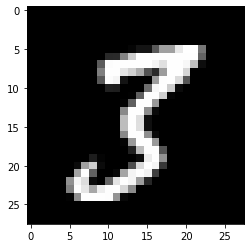

In [10]:
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

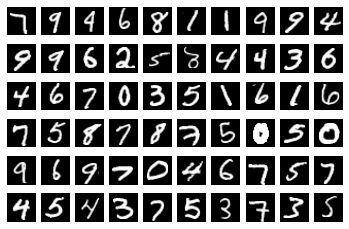

In [11]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
    plt.subplot(6,10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='Greys_r')

In [12]:
eps=1e-7
z_size = 50
ngf=32
nc = 1

# Define the discriminator network
Based on CNN from: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [13]:
class DiscriminatorConvNet(nn.Module):    
    def __init__(self):
        super(DiscriminatorConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=(2,2))
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 64)  # 5*5 from image dimension
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

D = DiscriminatorConvNet()
D

DiscriminatorConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
# test input
inp = torch.randn(2,1,28,28)
d_out = D(inp)
print(d_out)
d_image_out = D(images)
print(d_image_out.shape)

tensor([[0.5101],
        [0.5060]], grad_fn=<SigmoidBackward0>)
torch.Size([64, 1])


# Define the generator network

In [15]:
p_size = 4
# class GeneratorConvNet(nn.Module):
    
#     def __init__(self):
#         super(GeneratorConvNet, self).__init__()
#         self.fc1 = nn.Linear(z_size, 128)
#         self.fc2 = nn.Linear(128, 64 * p_size * p_size)
        
#         self.tconv1 = nn.ConvTranspose2d(64, 32, 5, dilation=2)
#         self.conv11 = nn.Conv2d(32, 32, 5, padding=2)
        
#         self.tconv2 = nn.ConvTranspose2d(32, 16, 5, dilation=2)
#         self.conv21 = nn.Conv2d(16, 16, 5, padding=2)
        
#         self.tconv3 = nn.ConvTranspose2d(16, 6, 5, dilation=2)
#         self.conv31 = nn.Conv2d(6, 1, 5, padding=2)
#         self.act1 =  nn.LeakyReLU(0.1)
#         self.act2 =  nn.LeakyReLU(0.2)
    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
# #         print(x.shape)
#         x = x.reshape(-1, 64, p_size, p_size)
#         x = self.act1(self.conv11(self.tconv1(x)))
# #         print(x.shape)
#         x = self.act2(self.conv21(self.tconv2(x)))
# #         print(x.shape)
#         x = F.sigmoid(self.conv31(self.tconv3(x)))
# #         print(x.shape)
#         return x
    
    # Experiment with learning rate, decrease learning rate
    # Try adding batch norm
    
# Generator Code

class GeneratorConvNet(nn.Module):
    def __init__(self):
        super(GeneratorConvNet, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_size, ngf * 2, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 2, ngf, 5, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf, nc, 4, 2, 0, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf , nc, 3, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
            # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

G = GeneratorConvNet()
G

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(50, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): Sigmoid()
  )
)

In [16]:
# test input
inp = torch.randn(2, z_size, 1, 1)
g_out = G(inp)
print(g_out.shape)

torch.Size([2, 1, 28, 28])


In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [18]:
# Try running G out through D
d_of_g_out = D(g_out)
print(d_of_g_out)

tensor([[0.5077],
        [0.5072]], grad_fn=<SigmoidBackward0>)


In [19]:
noise_generator = lambda x: torch.FloatTensor(x, z_size, 1, 1).uniform_(0, 1) # pg(z) torch.randn(x, z_size)
noise_generator(2).shape

torch.Size([2, 50, 1, 1])

# Train algorithm

In [20]:
# Define the train parameters
num_epochs = 12
batch_size = 128
k_steps = 1
num_val_batches = 10


In [21]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

#pdata(x)
train_real_sampler = iter(trainloader)
val_real_sampler = iter(valloader)

In [22]:
# pg(z)
noise_generator = lambda x: torch.FloatTensor(x, z_size, 1, 1).uniform_(0, 1).to(device)
noise_generator(2).shape

torch.Size([2, 50, 1, 1])

In [23]:
D_optim = optim.Adam(D.parameters(), lr=0.0001)
G_optim = optim.Adam(G.parameters(), lr=0.001)

In [24]:
D.to(device)
G.to(device)

# G.apply(weights_init)
# D.apply(weights_init)

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(50, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): Sigmoid()
  )
)

In [25]:
eps=1e-7
num_train_iterations = (len(trainloader) - num_val_batches - 1) // 1
D_of_data_out_avg = []
D_of_G_out_avg = []
D_loss = []
G_loss = []
generated_images = []
for e in range(num_epochs):
    # Train
    for n in tqdm(range(num_train_iterations)):
        # Update D for k steps
#         for k in range(k_steps):
            

        # Update D
        D.zero_grad()
        G.zero_grad()
        # D_optim.zero_grad()
        noise_samples = noise_generator(batch_size)
        data_samples, targets = next(train_real_sampler)
        data_samples = data_samples.to(device)

        D_out = D(data_samples)
        G_out = G(noise_samples)
        D_of_G_out = D(G_out)

        loss = torch.mean(torch.log(D_out+eps) + torch.log(1 - D_of_G_out+eps))
        # using log affects the space and curves of the function space
        ascend_loss = -1 * loss # multiply by -1 to force gradient ascent
#             D_out.backward(ascend_loss)
        ascend_loss.backward()
        D_optim.step()            
        D_loss.append(ascend_loss.detach().cpu().numpy())
        
        
        # Update G
        G.zero_grad()
        D.zero_grad()
        # G_optim.zero_grad()
        noise_samples = noise_generator(batch_size)

        G_out = G(noise_samples)
        D_of_G_out = D(G_out)

        loss = -1 * torch.mean(torch.log(D_of_G_out+eps))
        #             loss = torch.mean(torch.log(1 - D_of_G_out+eps))
        # Mean is independant of batch size, where as sum would be almost equivlient but depends on the batch size
        #         D_of_G_out.backward(loss)
        loss.backward()
        G_optim.step()
        G_loss.append(loss.detach().cpu().numpy())
        

    train_real_sampler = iter(trainloader)
    
    # Eval
    D_of_data_outs = []
    D_of_G_outs = []
    val_real_sampler = iter(valloader)
    for n in range(num_val_batches):
        noise_samples = noise_generator(batch_size)
        data_samples, targets = next(val_real_sampler)
        data_samples = data_samples.to(device)
        D_out = D(data_samples)
        G_out = G(noise_samples)
        
        D_of_data_outs.append(D_out.detach().cpu())
        D_of_G_outs.append(D(G_out).detach().cpu())

    D_of_data_out_avg.append(torch.mean(torch.cat(D_of_data_outs)).numpy())
    D_of_G_out_avg.append(torch.mean(torch.cat(D_of_G_outs)).numpy())
    if (0.49 < D_of_data_out_avg[-1] < 0.51) and (0.49 < D_of_G_out_avg[-1] < 0.51) and e > 20:
        break

    generated_images.append(G(noise_generator(1)).detach().cpu()[0].numpy().squeeze())
        
    

100%|█████████████████████████████████████████| 458/458 [00:08<00:00, 50.92it/s]


In [26]:
# D_of_data_out_avg = [1.2, 1.0, .7, .64, .5]
# D_of_G_out_avg = [0.3, 0.5, 0.7, 0.6, 0.5]
D_of_data_out_avg

[array(0.48332348, dtype=float32),
 array(0.70606065, dtype=float32),
 array(0.731258, dtype=float32),
 array(0.45925778, dtype=float32),
 array(0.6152804, dtype=float32),
 array(0.52165115, dtype=float32),
 array(0.72518045, dtype=float32),
 array(0.8230818, dtype=float32),
 array(0.86445075, dtype=float32),
 array(0.7876513, dtype=float32),
 array(0.827892, dtype=float32),
 array(0.86990005, dtype=float32)]

In [27]:
D_of_G_out_avg

[array(0.47185677, dtype=float32),
 array(0.47721562, dtype=float32),
 array(0.19839074, dtype=float32),
 array(0.38099033, dtype=float32),
 array(0.4301866, dtype=float32),
 array(0.305292, dtype=float32),
 array(0.16391936, dtype=float32),
 array(0.09557409, dtype=float32),
 array(0.21597579, dtype=float32),
 array(0.29837078, dtype=float32),
 array(0.15663975, dtype=float32),
 array(0.07274316, dtype=float32)]

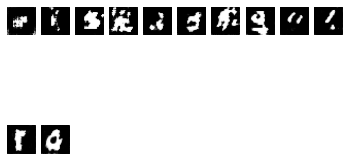

In [28]:
figure = plt.figure()
for index, image in enumerate(generated_images, start=1):
    plt.subplot((num_epochs//10) + 1, 10, index)
    plt.axis('off')
    plt.imshow(generated_images[index-1], cmap='Greys_r')

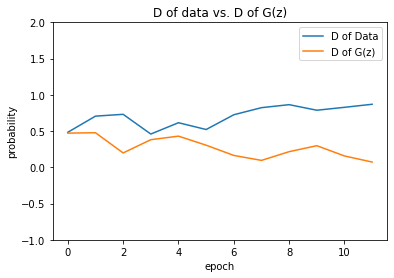

In [29]:
# line 1 points
x1 = range(len(D_of_data_out_avg))
y1 = D_of_data_out_avg
# plotting the line 1 points 
plt.plot(x1, y1, label = "D of Data")
# line 2 points
x2 = range(len(D_of_G_out_avg))
y2 = D_of_G_out_avg
# plotting the line 2 points 
plt.plot(x2, y2, label = "D of G(z)")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('probability')
# Set a title of the current axes.
plt.title('D of data vs. D of G(z)')
# show a legend on the plot
plt.legend()
plt.ylim([-1, 2])
# Display a figure.
plt.show()


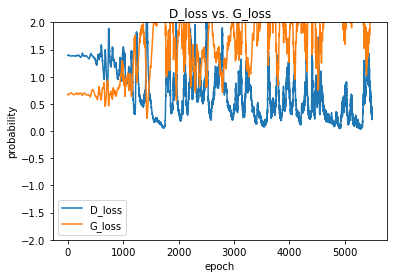

In [30]:
# line 1 points
x1 = range(len(D_loss))
y1 = D_loss
# plotting the line 1 points 
plt.plot(x1, y1, label = "D_loss")
# line 2 points
x2 = range(len(G_loss))
y2 = G_loss
# plotting the line 2 points 
plt.plot(x2, y2, label = "G_loss")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('probability')
# Set a title of the current axes.
plt.title('D_loss vs. G_loss')
# show a legend on the plot
plt.legend()
plt.ylim([-2, 2])
# Display a figure.
plt.show()


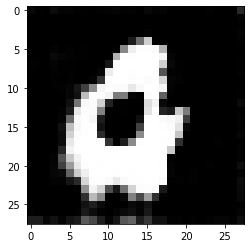

In [43]:
plt.imshow(G(noise_generator(1)).detach().cpu()[0].numpy().squeeze(), cmap='Greys_r')

In [32]:
# test input
inp = torch.randn(1,z_size, 1, 1).to(device)
g_out = G(inp)
print(g_out.shape)
print(g_out)

torch.Size([1, 1, 28, 28])
tensor([[[[2.8520e-02, 4.1441e-03, 2.2935e-03, 4.0525e-02, 1.4726e-02,
           1.7737e-02, 4.5636e-03, 6.2775e-03, 2.6347e-03, 1.0016e-02,
           1.1020e-02, 2.1027e-02, 9.7874e-03, 1.0786e-02, 3.3144e-03,
           2.5138e-02, 1.2701e-02, 1.9145e-02, 3.9077e-03, 5.5981e-03,
           2.6099e-03, 5.7155e-03, 4.0084e-03, 1.2232e-02, 1.6082e-03,
           9.3025e-04, 2.4754e-03, 1.4099e-01],
          [6.2831e-04, 2.3442e-05, 5.4391e-06, 7.1732e-04, 3.8708e-04,
           2.1960e-04, 1.3252e-05, 5.1388e-05, 5.5674e-06, 1.3918e-05,
           1.7535e-05, 8.0996e-04, 1.3381e-04, 2.0196e-05, 8.3173e-06,
           1.3144e-03, 2.9633e-04, 9.4982e-05, 8.5462e-06, 9.3633e-05,
           1.3934e-05, 2.1696e-05, 2.3385e-06, 1.2250e-04, 2.2604e-06,
           1.3810e-07, 4.4005e-06, 1.9162e-02],
          [6.6396e-05, 7.7826e-07, 1.0429e-07, 4.7081e-05, 1.0753e-05,
           1.1441e-05, 4.3126e-07, 9.3709e-07, 1.1982e-07, 3.1701e-06,
           8.1921e-07, 8.